# ***Libraries***

In [1]:
import math
import os
import sys
import json
from time import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

In [2]:
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length, plotFig, printResult

from TSB_UAD.models.iforest import IForest

## ***Data Pre-Processing***

In [3]:
# Load the data for the evaluation.
all_data = []

with open('dataset.pkl', 'rb') as f:
    data = pkl.load(f)

all_data.extend(data['evaluation']['single_normality'])
all_data.extend(data['evaluation']['double_normality'])
all_data.extend(data['evaluation']['triple_normality'])
all_data.extend(data['evaluation']['quadruple_normality'])

In [4]:
preprocessed_dict = {}

In [5]:
# Set the number of windows to be fit per batch.

for timeseries in all_data:
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised method
    name = timeseries['Name']

    data = timeseries['data']
    max_length = data.shape[0]
    label = timeseries['labels']

    slidingWindow = find_length(data)
    X_data = Window(window=slidingWindow).convert(data).to_numpy()

    print(f'Time-Series name: {name}')
    print("Full time series length: ", max_length)
    print("Estimated Subsequence length: ", slidingWindow)
    print()
    
    # Store the pre-processed variables in the new dictionary
    preprocessed_dict[name] = {
        'name': name,
        'data': data,
        'label': label,
        'slidingWindow': slidingWindow,
        'X_data': X_data,
        'Time series length': len(data),
        'Number of abnormal points': list(label).count(1)
    }

Time-Series name: ECG1
Full time series length:  229900
Estimated Subsequence length:  100

Time-Series name: ECG1_20k
Full time series length:  20000
Estimated Subsequence length:  100

Time-Series name: IOPS1
Full time series length:  8784
Estimated Subsequence length:  288

Time-Series name: SMD1
Full time series length:  28479
Estimated Subsequence length:  125

Time-Series name: Occupancy1
Full time series length:  2665
Estimated Subsequence length:  125

Time-Series name: ECG1+IOPS1
Full time series length:  28784
Estimated Subsequence length:  100

Time-Series name: SMD1+Occupancy1
Full time series length:  31144
Estimated Subsequence length:  125

Time-Series name: ECG1+IOPS1+Occupancy1
Full time series length:  31449
Estimated Subsequence length:  100

Time-Series name: SMD1+ECG1+Occupancy1
Full time series length:  51144
Estimated Subsequence length:  125

Time-Series name: ECG1+IOPS1+SMD1+Occupancy1
Full time series length:  59928
Estimated Subsequence length:  100



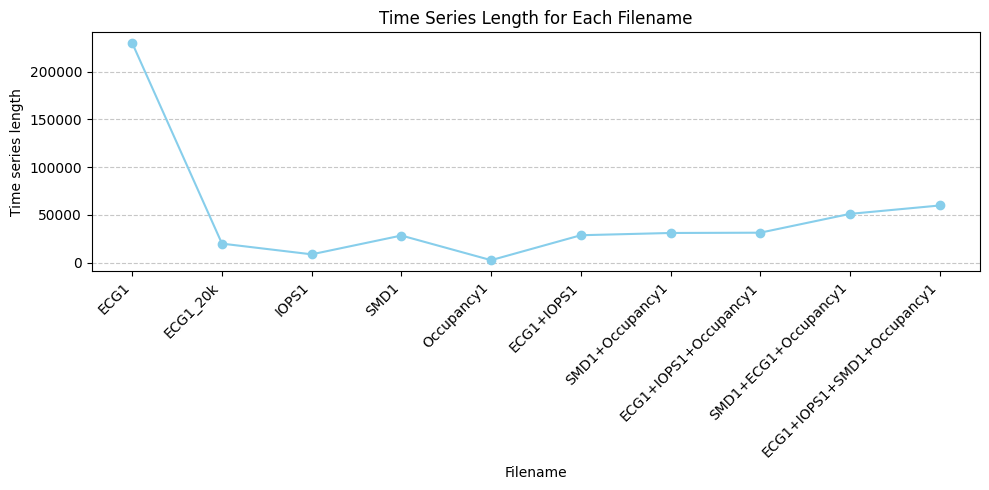

In [6]:
# Get filenames, time series lengths, and number of abnormal points
filenames = list(preprocessed_dict.keys())
time_series_lengths = [data['Time series length'] for data in preprocessed_dict.values()]
number_of_abnormal_points = [data['Number of abnormal points'] for data in preprocessed_dict.values()]

# Plot 'Time series length' and 'Number of abnormal points' for each filename
plt.figure(figsize=(10, 5))
plt.plot(filenames, time_series_lengths, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Filename')
plt.ylabel('Time series length')
plt.title('Time Series Length for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

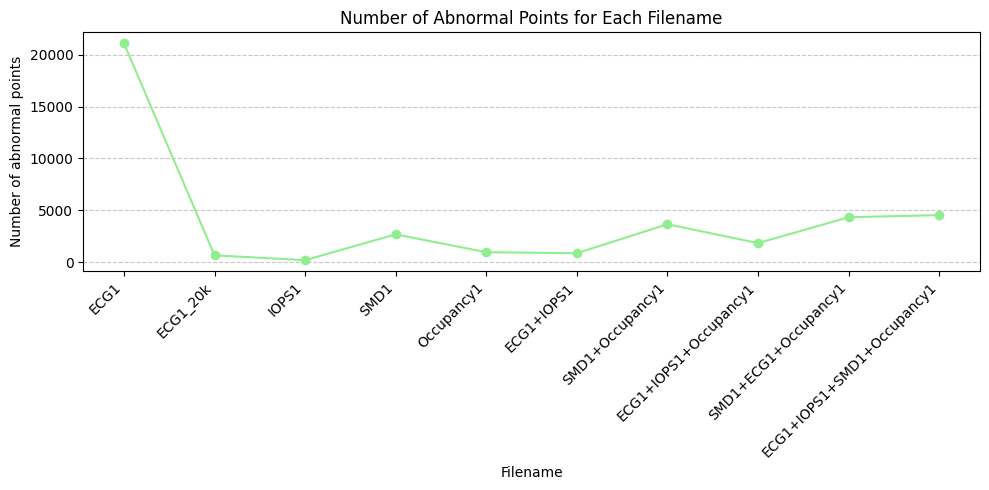

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(filenames, number_of_abnormal_points, marker='o', linestyle='-', color='lightgreen')
plt.xlabel('Filename')
plt.ylabel('Number of abnormal points')
plt.title('Number of Abnormal Points for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## ***Anomaly Detection***

### ***SAND***

In [9]:
from tqdm import tqdm
from TSB_UAD.models.sand import SAND

modelName = 'SAND'

In [10]:
results = []

for name in (p := tqdm(preprocessed_dict.keys())):
    p.set_description(name)
    ts = preprocessed_dict[name]
    x = ts['data']
    slidingWindow = ts['slidingWindow']
    
    clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
    t0 = time()
    clf.fit(x,online=True,alpha=0.5,init_length=500,batch_size=250,verbose=True,overlaping_rate=int(4*slidingWindow))
    t1 = time()
    score = clf.decision_scores_
    
    score = np.array(score)
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([name] + L + [t1-t0, len(x)])

ECG1:   0%|          | 0/10 [00:00<?, ?it/s]

0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->33000-->35000-->37000-->39000-->41000-->43000-->45000-->47000-->49000-->51000-->53000-->55000-->57000-->59000-->61000-->63000-->65000-->67000-->69000-->71000-->73000-->75000-->77000-->79000-->81000-->83000-->85000-->87000-->89000-->91000-->93000-->95000-->97000-->99000-->101000-->103000-->105000-->107000-->109000-->111000-->113000-->115000-->117000-->119000-->121000-->123000-->125000-->127000-->129000-->131000-->133000-->135000-->137000-->139000-->141000-->143000-->145000-->147000-->149000-->151000-->153000-->155000-->157000-->159000-->161000-->163000-->165000-->167000-->169000-->171000-->173000-->175000-->177000-->179000-->181000-->183000-->185000-->187000-->189000-->191000-->193000-->195000-->197000-->199000-->201000-->203000-->205000-->207000-->209000-->211000-->213000-->215000-->217000-->219000-->221000-->223000-->225000-->227000-->229000-->[STOP]: score length 229900


ECG1_20k:  10%|█         | 1/10 [10:04<1:30:44, 604.90s/it]

0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->

IOPS1:  20%|██        | 2/10 [10:09<33:35, 251.93s/it]     

[STOP]: score length 20000
0-->5000-->7000-->

SMD1:  30%|███       | 3/10 [10:10<16:00, 137.16s/it] 

[STOP]: score length 8784
0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->

SMD1:  40%|████      | 4/10 [10:18<08:37, 86.18s/it] 

[STOP]: score length 28479


ECG1+IOPS1:  50%|█████     | 5/10 [10:18<04:35, 55.16s/it]

0-->[STOP]: score length 2665
0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->[STOP]: score length 28784


SMD1+Occupancy1:  60%|██████    | 6/10 [10:27<02:38, 39.56s/it]

0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->[STOP]: score length 31144


ECG1+IOPS1+Occupancy1:  70%|███████   | 7/10 [10:37<01:29, 29.71s/it]

0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and

5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->[STOP]: score length 31449


SMD1+ECG1+Occupancy1:  80%|████████  | 8/10 [10:47<00:46, 23.45s/it] 

0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->33000-->35000-->37000-->39000-->41000-->43000-->45000-->47000-->49000-->[STOP]: score length 51144


ECG1+IOPS1+SMD1+Occupancy1:  90%|█████████ | 9/10 [11:09<00:22, 22.96s/it]

0-->

c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"
c:\Users\John\.conda\envs\TSB\lib\site-packages\sklearn\utils\validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and

5000-->7000-->9000-->11000-->13000-->15000-->17000-->19000-->21000-->23000-->25000-->27000-->29000-->31000-->33000-->35000-->37000-->39000-->41000-->43000-->45000-->47000-->49000-->51000-->53000-->55000-->57000-->59000-->[STOP]: score length 59928


ECG1+IOPS1+SMD1+Occupancy1: 100%|██████████| 10/10 [11:52<00:00, 71.23s/it]


In [14]:
columns = ['Name'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precision@k', 'RangeAUC', 'Time', 'Number of Windows']
df = pd.DataFrame(results, columns=columns)

In [15]:
df['Number of anomalies'] = df['Name'].apply(lambda x: np.sum(preprocessed_dict[x]['label']))
df[['Name', 'AUC', 'Precision@k', 'Number of anomalies', 'Time', 'Number of Windows']]

,Name,AUC,Precision@k,Number of anomalies,Time,Number of Windows
0,ECG1,0.786200,0.183085,21105.0,602.810285,229900
1,ECG1_20k,0.989924,0.702222,675.0,4.673897,20000
2,IOPS1,0.585822,0.000000,206.0,0.509092,8784
3,SMD1,0.513826,0.000000,2694.0,7.819358,28479
4,Occupancy1,0.723171,0.000000,972.0,0.123233,2665
5,ECG1+IOPS1,0.871617,0.520999,881.0,9.036849,28784
6,SMD1+Occupancy1,0.506766,0.000000,3666.0,9.202574,31144
7,ECG1+IOPS1+Occupancy1,0.817918,0.208311,1853.0,9.790071,31449
8,SMD1+ECG1+Occupancy1,0.768008,0.016586,4341.0,21.487252,51144
9,ECG1+IOPS1+SMD1+Occupancy1,0.530909,0.071036,4547.0,42.671428,59928


In [16]:
df.to_csv('Results/SAND/SAND-results.csv', index=False)